<a href="https://colab.research.google.com/github/themysterysolver/QR-CIP/blob/main/CODE/PHASE_1_REFINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy matplotlib opencv-python qrcode[pil] pycryptodome pillow

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import qrcode
import hashlib

- `cv2` is a part of *openCV* ***computer vision library***

In [7]:
def sha256_to_float(seed_string):
    hash_digest = hashlib.sha256(seed_string.encode()).hexdigest()
    print(hash_digest)
    hash_n = hash_digest[:16]
    return int(hash_n, 16) / 2**64

In [8]:
def lss_permutation(seed_string, n, r=3.9, s=3.0):#s is amplitutde,r-is logistic growth rate,pi-freq paramaeter
    x = sha256_to_float(seed_string)
    seq=[0]*n
    seq[0]=x
    for i in range(1,n):
      seq[i]=((r*seq[i-1]*(1-seq[i-1])) + s*np.sin(np.pi*seq[i-1]))%1
    permu_seq=np.argsort(seq)
    return np.array(permu_seq)

In [11]:
def crop_qr_border(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # If no contours found, return the original image
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    margin = 5
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(img.shape[1] - x, w + 2 * margin)
    h = min(img.shape[0] - y, h + 2 * margin)
    return img[y:y+h, x:x+w]

In [15]:
def divide_qr(img):
    if img.shape[0] % 4 != 0 or img.shape[1] % 4 != 0:
        img = cv2.resize(img, (400, 400))
    block_size = img.shape[0] // 4
    return np.array([img[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size] for i in range(4) for j in range(4)])

In [16]:
def scramble_qr(blocks, permutation):
    return blocks[permutation.tolist()] #converts into list

In [17]:
def rebuild_matrix(blocks):
    return np.vstack([np.hstack(blocks[i * 4:(i + 1) * 4]) for i in range(4)])

In [21]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

### AES
- (AES) **Advanced encryption Standard**
- AES works only on bytes
- `IV` is *iniialization vector*
- `CBC` is *cyber block chaining*
  - AES works with fixed-size blocks of `16 bytes` (128 bits).
  - if greater than that exist,it happens ***multiple rounds*** dividing into multiple *16byte block* .

<br>

- AES does XOR of plain text and previous $c_i$
- Encryption
$C_i = E_k ( P_i \oplus C_{i-1} )$
- when **no 1st** block
$C_1 = E_k ( P_1 \oplus IV )$
- Decrytption
$P_i = D_k ( C_i ) \oplus C_{i-1}$
- when no 1st block
$P_1 = D_k ( C_1 ) \oplus IV$

<br>

- AES I/P:
  - Plaintext (original data)
  - Secret key (16, 24, or 32 bytes)
  - Encryption process → Produces ciphertext (unreadable data)
  - Decryption process → Converts ciphertext back to plaintext using the same key.
<br>

## O/P
```
[ IV (16 bytes) ] + [ Encrypted Data (multiple of 16 bytes) ]

```

In [22]:
def encrypt_aes(data, key):
    cipher = AES.new(key, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(data, AES.block_size))
    return cipher.iv + ct_bytes

Enter a string for SHA-256-based permutation:hello
2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824
[ 6  1  0 13  3 14  7  4 10 15  8 11  2 12  5  9]
Enter a string to generate a QR code: wow
(290, 290, 3)
(220, 210, 3)
(400, 400, 3)
(16, 100, 100, 3)
(16, 100, 100, 3)
(400, 400, 3)
QR Code:


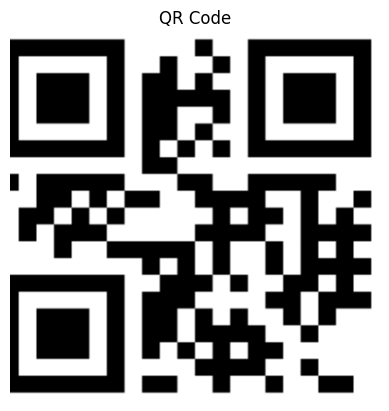

Scrambled QR Code:


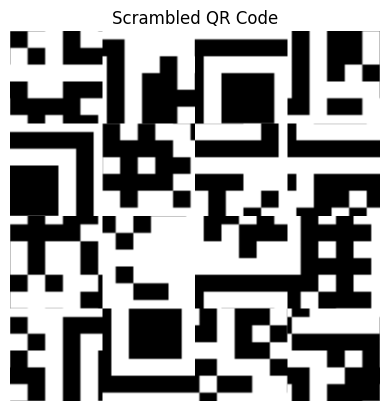

b"\xb6\xdc\x933\x11\xbc#W\xcc_\xc66\xa4\xdb\xe4\x1a\x01\xb7\xa3;X=\x04:\x7f\x87\x0f4@i~'"
AES-Encrypted Scrambled QR Code:


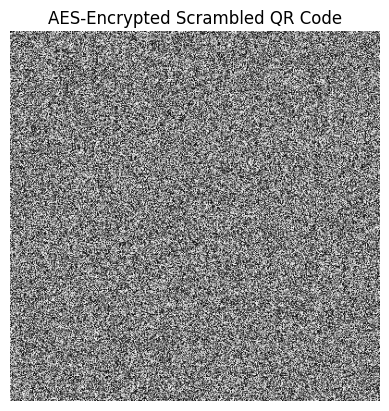

In [24]:
if __name__ == "__main__":
    sha256_input = input("Enter a string for SHA-256-based permutation:")
    n=16
    permutation=lss_permutation(sha256_input,n)
    print(permutation)

    qr_input = input("Enter a string to generate a QR code: ")
    qr=qrcode.make(qr_input)
    qr.save("qr_code.png")

    img=cv2.imread("qr_code.png")
    print(img.shape)

    img = crop_qr_border(img)
    print(img.shape)

    img = cv2.resize(img, (400, 400))
    print(img.shape)

    divided_blocks = divide_qr(img)
    print(divided_blocks.shape)

    scrambled_blocks = scramble_qr(divided_blocks, permutation)
    print(scrambled_blocks.shape)

    scrambled_qr = rebuild_matrix(scrambled_blocks)
    print(scrambled_qr.shape)

    print("QR Code:")
    plt.imshow(img, cmap='gray')
    plt.title("QR Code")
    plt.axis('off')
    plt.show()

    print("Scrambled QR Code:")
    plt.imshow(scrambled_qr, cmap='gray')
    plt.title("Scrambled QR Code")
    plt.axis('off')
    plt.show()

    hash_digest = hashlib.sha256(qr_input.encode()).digest() #256-bits (32bytes)
    aes_key=hash_digest[:]
    print('aes_key:',hash_digest)
    encrypted_qr=encrypt_aes(scrambled_qr.tobytes(),hash_digest)

    print("AES-Encrypted Scrambled QR Code:")
    encrypted_qr_array = np.frombuffer(encrypted_qr, dtype=np.uint8) #bytes->numpy array of uint8
    encrypted_qr_2d = encrypted_qr_array[:400*400].reshape((400, 400))  # Reshape to 2D for visualization
    plt.imshow(encrypted_qr_2d, cmap='gray')
    plt.title("AES-Encrypted Scrambled QR Code")
    plt.axis('off')
    plt.show()



- That's how a `290*290*3` array look like,290 rows and column with 3 cols each for ***rgb***
```
[
  [[255, 255, 255], [255, 255, 255], [255, 255, 255], ..., [255, 255, 255]],
  [[255, 255, 255], [0, 0, 0], [0, 0, 0], ..., [255, 255, 255]],
  [[255, 255, 255], [0, 0, 0], [0, 0, 0], ..., [255, 255, 255]],
  ...,
  [[255, 255, 255], [0, 0, 0], [0, 0, 0], ..., [255, 255, 255]]
]
```